config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

C:\Users\assem\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\assem\.cache\huggingface\hub\models--dbmdz--bert-large-cased-finetuned-conll03-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Device set to use cpu


Named Entities: [{'entity': 'I-MISC', 'score': 0.56055605, 'index': 10, 'word': 'PC', 'start': 43, 'end': 45}, {'entity': 'I-ORG', 'score': 0.9947448, 'index': 24, 'word': 'The', 'start': 95, 'end': 98}, {'entity': 'I-ORG', 'score': 0.7757066, 'index': 25, 'word': '##rm', 'start': 98, 'end': 100}, {'entity': 'I-ORG', 'score': 0.97065955, 'index': 26, 'word': '##o', 'start': 100, 'end': 101}, {'entity': 'I-ORG', 'score': 0.9969723, 'index': 27, 'word': 'Fisher', 'start': 102, 'end': 108}, {'entity': 'I-ORG', 'score': 0.98993707, 'index': 28, 'word': 'Scientific', 'start': 109, 'end': 119}, {'entity': 'I-ORG', 'score': 0.8195044, 'index': 65, 'word': 'SP', 'start': 261, 'end': 263}]


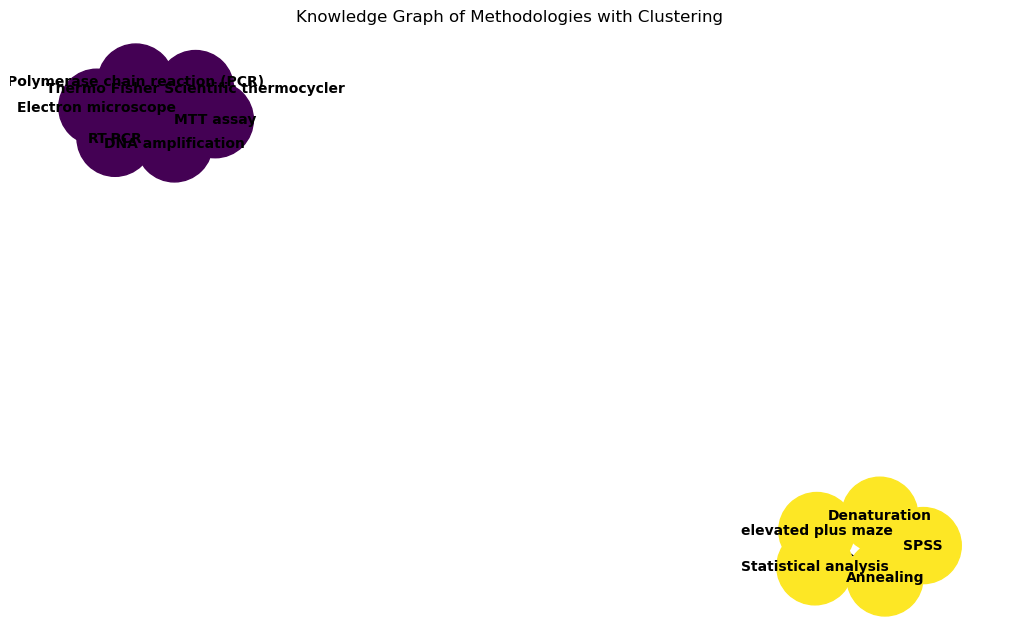

In [4]:
# Import necessary libraries
import torch
from transformers import pipeline
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer

# Example Methods Section (Text from a scientific paper)
methods_text = """
In this study, polymerase chain reaction (PCR) was used for DNA amplification. 
We employed a Thermo Fisher Scientific thermocycler at 95°C for denaturation and 60°C for annealing. 
Samples were analyzed using an electron microscope. 
Data was processed using SPSS for statistical analysis.
"""

# 1. Named Entity Recognition (NER) using HuggingFace's pre-trained model (e.g., BERT)
nlp_ner = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")

# Run NER on the methods text
ner_results = nlp_ner(methods_text)
print("Named Entities:", ner_results)

# 2. Extract the relevant entities (e.g., techniques, tools)
techniques = ["Polymerase chain reaction (PCR)", "MTT assay", "RT-PCR", "elevated plus maze"]
tools = ["Thermo Fisher Scientific thermocycler", "Electron microscope", "SPSS"]
processes = ["DNA amplification", "Denaturation", "Annealing", "Statistical analysis"]

# Combine them into a list of entities to work with
entities = techniques + tools + processes

# 3. Generate embeddings using HuggingFace's sentence transformers for semantic clustering
model = SentenceTransformer('all-MiniLM-L6-v2')

# Create embeddings for the entities
embeddings = model.encode(entities)

# 4. Perform Agglomerative Clustering on the embeddings to group similar methodologies
clustering = AgglomerativeClustering(n_clusters=2, metric='cosine', linkage='average')  # Use 'metric' instead of 'affinity'
cluster_labels = clustering.fit_predict(embeddings)

# 5. Create a knowledge graph using NetworkX to represent the entities and relationships
G = nx.Graph()

# Add nodes based on identified entities
for i, entity in enumerate(entities):
    G.add_node(entity, cluster=cluster_labels[i])

# Add edges based on semantic similarity (clustering)
for i in range(len(entities)):
    for j in range(i + 1, len(entities)):
        # If they belong to the same cluster, add an edge
        if cluster_labels[i] == cluster_labels[j]:
            G.add_edge(entities[i], entities[j])

# Visualize the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)
labels = nx.get_node_attributes(G, 'label')
node_colors = [cluster_labels[i] for i in range(len(entities))]  # Color nodes by clusters

nx.draw(G, pos, with_labels=True, node_color=node_colors, font_size=10, node_size=3000, font_weight='bold')
plt.title("Knowledge Graph of Methodologies with Clustering")
plt.show()